In [11]:
import numpy as np
import matplotlib.pyplot as plt

from trader import Trader
from order_book import OrderBook

In [12]:
# initialise the trader and the order book
# here we will make just one trader make all the transactions
trader = Trader()
book = OrderBook()

np.random.seed(7)

In [13]:
def append_book_state(book, time):
    book_state = []
    for i, (price, quantity) in enumerate(book.asks):
        book_state.append([time, price, quantity, 'ask'])
    for i, (price, quantity) in enumerate(book.bids):
        book_state.append([time, price, quantity, 'bid'])

    return book_state

In [14]:
# new we want to generate some order book snapshot.
# to do this, let's first fill the order book with some random trades
mid_price = 100
tick_size = 1
book_depth = 5
simulation_length = 100

book_state_sequence = []
mid_price_sequence = []
microprice_sequence = []

# fill the ask and bid with random limit orders.
# in this example, we set the quantity with a uniform distribution from 1 to 30.
for i in range(1, book_depth + tick_size, tick_size):
    # ask
    trader.submit_order_to_order_book(
        order_type='limit_sell', 
        price=mid_price + i, 
        quantity=int(np.random.uniform(low=80, high=100)), 
        book=book)
    
    # bid
    trader.submit_order_to_order_book(
        order_type='limit_buy', 
        price=mid_price - i, 
        quantity=int(np.random.uniform(low=80, high=100)), 
        book=book)

    mid_price = book.get_mid_price()

print("Order book at time 0")
book.print_order_book_state()
book_state_sequence.append(append_book_state(book, 0))
mid_price_sequence.append(mid_price)
microprice_sequence.append(book.get_micro_price())

# now let's do some random trades
# in this example, we set the quantity with a uniform distribution from 1 to 30.
for i in range(1, simulation_length+1):
    order_type = np.random.choice(['limit_sell', 'limit_buy', 'market_buy', 'market_sell'])
    if order_type  == 'limit_sell':
        price = int(mid_price + np.random.normal(0,1) + tick_size) // tick_size
    elif order_type == 'limit_buy':
        price = int(mid_price - np.random.normal(0,1) - tick_size) // tick_size
    else:
        price = None

    quantity = int(np.random.uniform(low=1, high=10))
                   
    trader.submit_order_to_order_book(
        order_type=order_type, 
        price=price, 
        quantity=quantity,
        book=book)
    
    # update the mid price
    mid_price = book.get_mid_price()

    print(f"{order_type} - price: {price} - quantity: {quantity}")

    print(f"Order book at time {i}")
    book.print_order_book_state()

    book_state_sequence.append(append_book_state(book, i))
    mid_price_sequence.append(mid_price)
    microprice_sequence.append(book.get_micro_price())



Order book at time 0
+-------+----------+------+
| price | quantity | side |
+-------+----------+------+
| 105.0 |    85    | ask  |
| 104.0 |    90    | ask  |
| 103.0 |    99    | ask  |
| 102.0 |    88    | ask  |
|  101  |    81    | ask  |
|   99  |    95    | bid  |
|  98.0 |    94    | bid  |
|  97.0 |    90    | bid  |
|  96.0 |    81    | bid  |
|  95.0 |    89    | bid  |
+-------+----------+------+

limit_sell - price: 100 - quantity: 4
Order book at time 1
+-------+----------+------+
| price | quantity | side |
+-------+----------+------+
| 105.0 |    85    | ask  |
| 104.0 |    90    | ask  |
| 103.0 |    99    | ask  |
| 102.0 |    88    | ask  |
|  101  |    81    | ask  |
|  100  |    4     | ask  |
|   99  |    95    | bid  |
|  98.0 |    94    | bid  |
|  97.0 |    90    | bid  |
|  96.0 |    81    | bid  |
|  95.0 |    89    | bid  |
+-------+----------+------+

market_sell - price: None - quantity: 3
Order book at time 2
+-------+----------+------+
| price | quantit

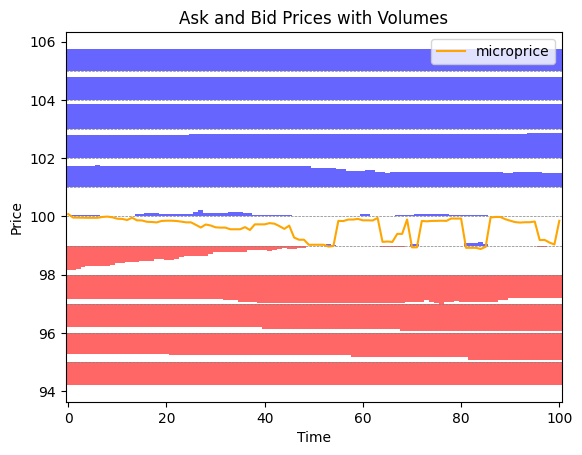

In [15]:
# Separiamo i dati per ask e bid
ask_data = [item for sublist in book_state_sequence for item in sublist if item[3] == 'ask']
bid_data = [item for sublist in book_state_sequence for item in sublist if item[3] == 'bid']

# Estraiamo i prezzi e i volumi
ask_times, ask_prices, ask_volumes = zip(*[(d[0], d[1], d[2]) for d in ask_data])
bid_times, bid_prices, bid_volumes = zip(*[(d[0], d[1], d[2]) for d in bid_data])

# Normalizziamo i volumi
max_volume = max(max(ask_volumes), max(bid_volumes))
norm_ask_volumes = [v / max_volume for v in ask_volumes]
norm_bid_volumes = [v / max_volume for v in bid_volumes]

# Creiamo il grafico
fig, ax = plt.subplots()

# Plottiamo gli ask
for t, p, v in zip(ask_times, ask_prices, norm_ask_volumes):
    ax.bar(t, v, width=1, bottom=p, color='blue', alpha=0.6)

# Plottiamo i bid
for t, p, v in zip(bid_times, bid_prices, norm_bid_volumes):
    ax.bar(t, -v, width=1, bottom=p, color='red', alpha=0.6)

# Aggiungiamo le linee di griglia per le bande di prezzo
prices = sorted(set(ask_prices + bid_prices))
for price in prices:
    ax.axhline(y=price, color='grey', linestyle='--', linewidth=0.5)

# Etichettiamo gli assi
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Ask and Bid Prices with Volumes')

# Impostiamo i limiti dell'asse X per evitare spazi vuoti tra i dati
ax.set_xlim(min(ask_times + bid_times) - 0.5, max(ask_times + bid_times) + 0.5)

#x, y = zip(*[[i, v] for (i, v) in enumerate(mid_price_sequence)])
#ax.plot(x, y, color='green', label='price mid')

x, y = zip(*[[i, v] for (i, v) in enumerate(microprice_sequence)])
ax.plot(x, y, color='orange', label='microprice')

ax.legend(loc='upper right')
# Mostriamo il grafico
plt.show()

